### Problem Statement

   Crossfit and Orange Theory are two of the biggest fitness regimen studios in the country. Both boast huge followings in memberships and in online presence as well. While they both aim to get you in shape through exercise, their methods differ on how to achieve your fitness goals. Crossfit is known to have a bigger strength training component to its workouts, while Orange Theory emphasizes cardio more.
   
   As a data scientist, the purpose of this project is to use data from the respective subreddits of each gym to build a model that will be able to differentiate between the two when given a sample of text. From there, I am hoping to be able to make a prediciton on which group is happier/more satisfied with their workouts.

#### Imports

In [129]:
import requests
import time

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split,cross_val_score,GridSearchCV
from sklearn.metrics import r2_score,mean_squared_error,confusion_matrix,accuracy_score, plot_confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier

from nltk.stem import PorterStemmer,WordNetLemmatizer
from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer


### Data Collection

In [2]:
url = 'https://api.pushshift.io/reddit/search/submission'

In [3]:
params = {
    'subreddit': 'crossfit',
}

res = requests.get(url, params=params)

res.status_code

data = res.json()

data['data'][-1]['created_utc']

1624946574

##### ORANGE THEORY API CALLS (1000 POSTS)

In [4]:
url = "https://api.pushshift.io/reddit/search/submission"
subreddit = 'orangetheory'
before = 1624106335

otf_df_list = []

for _ in range(10):
    
    params = {
        'subreddit': subreddit,
        'size': 100,
        'before': before
    }

    res = requests.get(url, params=params)
    json = res.json()
    
    before = json['data'][-1]['created_utc']
    print(f"before updated to {before}")
    
    # need the 'data' from the json
    dataframe = pd.DataFrame(res.json()['data'])
    otf_df_list.append(dataframe)
    
    time.sleep(5)
    
# CREDIT -- adapted from Caroline Schmitt code-along practice.

before updated to 1623864083
before updated to 1623631683
before updated to 1623385253
before updated to 1623181910
before updated to 1622996066
before updated to 1622753690
before updated to 1622503721
before updated to 1622232916
before updated to 1621990207
before updated to 1621728021


In [5]:
otf_df = pd.concat(otf_df_list).reset_index(drop=True)

In [6]:
otf_df[['author_fullname','title', 'selftext', 'score', 'subreddit']].head()

,author_fullname,title,selftext,score,subreddit
0,t2_38cndng5,Disc replacement,Not looking for medical advice just curious if...,1,orangetheory
1,t2_4k54qa7s,What are your cues that you need a few days off?,How can you tell when you need to take a few d...,3,orangetheory
2,t2_8162kxd9,Burnsville or Apple Valley MN studio,"I will be in Lakeville MN next week, thinking ...",2,orangetheory
3,t2_ct4fexde,OTF… Feels like the 80’’s Highschool Cliche - ...,[removed],1,orangetheory
4,t2_3wl9qh0n,"Daily Workout and General Chat for Saturday, 6...",Use this post to discuss today's OTF workout o...,8,orangetheory


In [7]:
# Saving OrangeTheory dataset
otf_df.to_csv('datasets/orangetheory.csv', index=False)

##### CROSSFIT API CALLS (1000 POSTS)

In [8]:
# CROSSFIT API CALLS (1000 POSTS)

url = "https://api.pushshift.io/reddit/search/submission"
subreddit = 'crossfit'
before = 1624032709

cf_df_list = []

for _ in range(10):
    
    params = {
        'subreddit': subreddit,
        'size': 100,
        'before': before
    }

    res = requests.get(url, params=params)
    json = res.json()
    
    before = json['data'][-1]['created_utc']
    print(f"before updated to {before}")
    
    # need the 'data' from the json
    dataframe = pd.DataFrame(res.json()['data'])
    cf_df_list.append(dataframe)
    
    time.sleep(5)
    
# CREDIT -- adapted from Caroline Schmitt code-along practice.

before updated to 1623863832
before updated to 1623420820
before updated to 1623069913
before updated to 1622645908
before updated to 1622242893
before updated to 1621830189
before updated to 1621355617
before updated to 1620864789
before updated to 1620413434
before updated to 1619994953


In [9]:
cf_df = pd.concat(cf_df_list).reset_index(drop=True)

In [10]:
cf_df[['author_fullname','title', 'selftext', 'score', 'subreddit']].head()

,author_fullname,title,selftext,score,subreddit
0,t2_csrgfn7p,Good morning! [F]eeling ready for anything big...,,1,crossfit
1,t2_8nen3fhq,Training together! @unbrokenshopcom,,4,crossfit
2,t2_csqpwk62,[f]reshly shaved just for GW,,1,crossfit
3,t2_3dciap6h,Recovery post vasectomy,[removed],1,crossfit
4,t2_csq03bf0,"(F19) damn, I really disappeared huh, well, in...",,1,crossfit


In [11]:
# Saving Crossfit dataset
cf_df.to_csv('datasets/crossfit.csv', index=False)

### Data Cleaning & EDA

In [12]:
otf_df.shape

(1000, 80)

In [13]:
cf_df.shape

(1000, 76)

In [14]:
# Creating new dataframes with the columns I want

otf_df = otf_df[['author_fullname','title', 'selftext', 'score', 'subreddit']]

cf_df = cf_df[['author_fullname','title', 'selftext', 'score', 'subreddit']]

In [15]:
# Combining newly created datafames into one dataframe 

gyms_df = pd.concat([otf_df, cf_df], ignore_index=True)

In [16]:
gyms_df.shape

(2000, 5)

In [17]:
gyms_df.head()

,author_fullname,title,selftext,score,subreddit
0,t2_38cndng5,Disc replacement,Not looking for medical advice just curious if...,1,orangetheory
1,t2_4k54qa7s,What are your cues that you need a few days off?,How can you tell when you need to take a few d...,3,orangetheory
2,t2_8162kxd9,Burnsville or Apple Valley MN studio,"I will be in Lakeville MN next week, thinking ...",2,orangetheory
3,t2_ct4fexde,OTF… Feels like the 80’’s Highschool Cliche - ...,[removed],1,orangetheory
4,t2_3wl9qh0n,"Daily Workout and General Chat for Saturday, 6...",Use this post to discuss today's OTF workout o...,8,orangetheory


In [18]:
gyms_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   author_fullname  1980 non-null   object
 1   title            2000 non-null   object
 2   selftext         1998 non-null   object
 3   score            2000 non-null   int64 
 4   subreddit        2000 non-null   object
dtypes: int64(1), object(4)
memory usage: 78.2+ KB


In [95]:
gyms_df.describe()

,score,sub_value,title_length,selftext_length,title_word_count,selftext_word_count
count,1964.000000,1964.000000,1964.000000,1964.000000,1964.000000,1964.00000
mean,3.806517,0.502546,41.633910,296.705703,7.466904,56.63391
std,20.007570,0.500121,34.114531,438.423344,6.508463,85.43157
min,0.000000,0.000000,2.000000,0.000000,1.000000,0.00000
25%,1.000000,0.000000,21.000000,0.000000,4.000000,0.00000
50%,1.000000,1.000000,32.000000,154.000000,6.000000,29.00000
75%,1.000000,1.000000,51.000000,438.250000,9.000000,80.00000
max,315.000000,1.000000,299.000000,3950.000000,60.000000,700.00000


In [20]:
gyms_df.isnull().sum().sort_values(ascending=False)

author_fullname    20
selftext            2
title               0
score               0
subreddit           0
dtype: int64

In [21]:
gyms_df.duplicated().sum()

16

In [22]:
gyms_df['subreddit'].value_counts()

crossfit        1000
orangetheory    1000
Name: subreddit, dtype: int64

In [23]:
# Dropping duplicate rows (16 duplicates) and resetting the index
gyms_df.drop_duplicates(keep='first', inplace=True)

gyms_df.reset_index(drop=True, inplace=True)

In [24]:
# Dropping rows with null values (20 rows)
gyms_df[gyms_df['author_fullname'].isna()]

gyms_df.drop(gyms_df[gyms_df['author_fullname'].isna()].index, inplace=True)

In [25]:
# 779 rows with 'selftext' column either removed, deleted, or empty
gyms_df[(gyms_df['selftext'] == '')|(gyms_df['selftext'] == '[removed]')|(gyms_df['selftext'] == '[deleted]')]

,author_fullname,title,selftext,score,subreddit
3,t2_ct4fexde,OTF… Feels like the 80’’s Highschool Cliche - ...,[removed],1,orangetheory
5,t2_cbi9mb4l,What does this blue clock no number mean?,,0,orangetheory
6,t2_cssfpylr,💜 Sex 💝 Server 💞,,1,orangetheory
15,t2_4z7tdy6l,New studio in Tampa!,,2,orangetheory
27,t2_6pcbagcd,Lower leg muscle knots,[removed],1,orangetheory
...,...,...,...,...,...
1976,t2_rrr1s,CrossFit 2020 documentary trailer,[removed],1,crossfit
1978,t2_9k2bitr2,Josh Matt Sevan,[removed],1,crossfit
1980,t2_9f0qx03x,"CrossFit Gyms near Ashburn, VA?",[removed],1,crossfit
1981,t2_jha4a,Resources of servicing/repairing airdyne ad4,[removed],1,crossfit


In [26]:
# Replacing [removed] and [deleted] values in 'selftext' column with empty string
gyms_df['selftext'].replace({'[removed]': '', '[deleted]': ''}, inplace=True)

In [27]:
# Creating target feature column
gyms_df['sub_value'] = gyms_df['subreddit'].map({'orangetheory': 1, 'crossfit': 0})

In [28]:
gyms_df.shape

(1964, 6)

In [29]:
# Function to clean up posts
# Adapted from : https://towardsdatascience.com/nlp-building-text-cleanup-and-preprocessing-pipeline-eba4095245a0

def clean_post(post):
    # Remove HTML 
    post = re.sub(r'\&\w*;', '', post)
    # lowercase
    post = post.lower()
    # Remove hyperlinks
    post = re.sub(r'https?:\/\/.*\/\w*', '', post)
    # Remove whitespace
    post = re.sub(r'\s\s+', ' ', post)
    # Remove single space at front of post
    post = post.lstrip(' ') 
    return post


In [30]:
# clean posts for gyms_df 

gyms_df['title'] = gyms_df['title'].map(clean_post)
gyms_df['selftext'] = gyms_df['selftext'].map(clean_post)


#### Distributions

In [167]:
# top 20 words in otf_df

cvec = CountVectorizer(stop_words='english')
cvec.fit(otf_df['title'])

otf_df_cv = pd.DataFrame(cvec.transform(otf_df['title']).todense(),columns=cvec.get_feature_names())
top_otf = otf_df_cv.sum(axis=0).sort_values(ascending=False)

df_top_otf = top_otf.to_frame(name='count')
df_top_otf['word'] = df_top_otf.index
df_top_otf.reset_index(drop=True, inplace=True)
df_top_otf['freq'] = df_top_otf['count'] / len(otf_df) * 100

cols = ['word','count','freq']
df_top_otf = df_top_otf[cols]
df_top_otf.sort_values(by='count',ascending=False, inplace=True)
df_top_otf.head(20)

,word,count,freq
0,otf,91,9.1
1,class,65,6.5
2,workout,54,5.4
3,21,39,3.9
4,2g,38,3.8
5,2021,38,3.8
6,60,36,3.6
7,mayhem,35,3.5
8,benchmark,35,3.5
9,mile,34,3.4


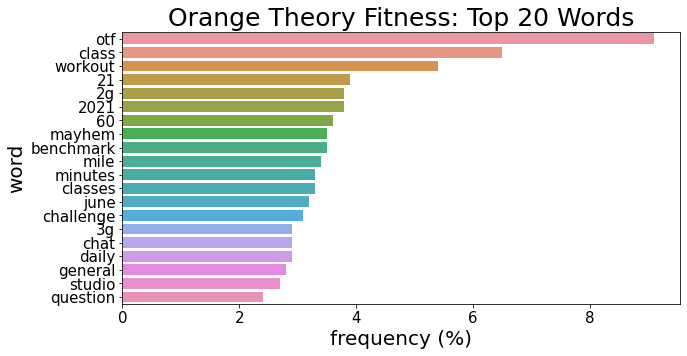

In [171]:
# PLot OTF top 20 words
plt.figure(figsize=(10,5))
sns.barplot(data=df_top_otf.head(20),x='freq',y='word',orient='h')

plt.title('Orange Theory Fitness: Top 20 Words',fontsize=25)
plt.xlabel('frequency (%)',fontsize=20)
plt.ylabel('word',fontsize=20)
plt.tick_params(labelsize=15);

plt.savefig('images/top_words_otf.png')

In [168]:
# top 20 words in cf_df

cvec = CountVectorizer(stop_words='english')
cvec.fit(cf_df['title'])

cf_df_cv = pd.DataFrame(cvec.transform(cf_df['title']).todense(),columns=cvec.get_feature_names())
top_cf = cf_df_cv.sum(axis=0).sort_values(ascending = False).head(20)

df_top_cf = top_cf.to_frame(name='count')
df_top_cf['word'] = df_top_cf.index
df_top_cf.reset_index(drop=True, inplace=True)
df_top_cf['freq'] = df_top_cf['count'] / len(cf_df) * 100

cols = ['word','count','freq']
df_top_cf = df_top_cf[cols]
df_top_cf.sort_values(by='count',ascending=False, inplace=True)
df_top_cf.head(20)

,word,count,freq
0,crossfit,139,13.9
1,2021,37,3.7
2,new,35,3.5
3,gym,35,3.5
4,workout,33,3.3
5,day,30,3.0
6,time,27,2.7
7,training,27,2.7
8,help,26,2.6
9,box,26,2.6


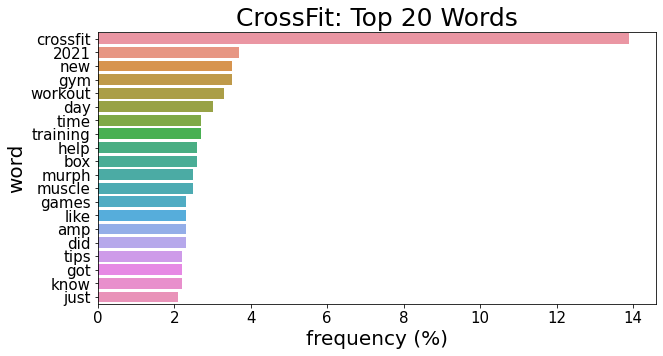

In [170]:
# Plot CF top 20 words
plt.figure(figsize=(10,5))
sns.barplot(data=df_top_cf.head(20),x='freq',y='word',orient='h')

plt.title('CrossFit: Top 20 Words',fontsize=25)
plt.xlabel('frequency (%)',fontsize=20)
plt.ylabel('word',fontsize=20)
plt.tick_params(labelsize=15);

plt.savefig('images/top_words_cf.png')

### Preprocessing & Modeling

In [39]:
type(stopwords.words('english'))

list

In [40]:
my_stopwords = stopwords.words('english')

In [41]:
print(my_stopwords) # words to remove - 'not', 'no', 'out'

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [42]:
# Adding 'otf' and 'crossfit' to my_stopwords bc they show up a lot in both subreddits
# want to prevent model overfitting
# .extend works like .append except you can add more than one item in a list
my_stopwords.extend(['otf', 'crossfit'])

In [43]:
# Romoving words from my_stopwords list that might negatively impact sentiment analysis
my_stopwords.remove('out')

my_stopwords.remove('no')

my_stopwords.remove('not')

In [44]:
def stopword_filter(post):
  
    return [word for word in post.lower().split() if word.lower() not in my_stopwords]


In [45]:
# Create function to tokenize 'title' and filter out stopwords
def tokenizer(post):
    tokenizer = RegexpTokenizer(r'\w+')
#     return tokenizer.tokenize(' '.join(stopword_filter(post))) - DO NOT RUN
    return stopword_filter(' '.join(tokenizer.tokenize(post)))

# Create new column with Tokens
gyms_df['title_tokens'] = gyms_df['title'].map(tokenizer)
gyms_df['selftext_tokens'] = gyms_df['selftext'].map(tokenizer)


In [46]:
# Create function classes to 'stem' and 'lemmatize' tokens used in pipeline vectorizers
# Adapted from: https://scikit-learn.org/stable/modules/feature_extraction.html

class Lemmatizer:
    def __init__(self):
        self.wnl = WordNetLemmatizer()
    def __call__(self, post):
        return [self.wnl.lemmatize(p) for p in post.split()]

class Stemmer:
    def __init__(self):
        self.ps = PorterStemmer()
    def __call__(self, post):
        return [self.ps.stem(p) for p in post.split()]

In [48]:
# Trying to find rows which have empty lists for 'title_tokens' and 'selftext_tokens'
# but can't figure it out
gyms_df[gyms_df['title_tokens'] == '[]']

,author_fullname,title,selftext,score,subreddit,sub_value,title_tokens,selftext_tokens


In [49]:
# columns for length of each 'title' and 'selftext' posts
gyms_df['title_length'] = gyms_df['title'].map(len)
gyms_df['selftext_length'] = gyms_df['selftext'].map(len)

In [50]:
gyms_df.head(1)

,author_fullname,title,selftext,score,subreddit,sub_value,title_tokens,selftext_tokens,title_length,selftext_length
0,t2_38cndng5,disc replacement,not looking for medical advice just curious if...,1,orangetheory,1,"[disc, replacement]","[not, looking, medical, advice, curious, anyon...",16,310


In [51]:
# columns for word count of 'title' and 'selftext' posts
def word_count(post):
    return len(post.split())

gyms_df['title_word_count'] = gyms_df['title'].map(word_count)
gyms_df['selftext_word_count'] = gyms_df['selftext'].map(word_count)

In [52]:
gyms_df.head(1)

,author_fullname,title,selftext,score,subreddit,sub_value,title_tokens,selftext_tokens,title_length,selftext_length,title_word_count,selftext_word_count
0,t2_38cndng5,disc replacement,not looking for medical advice just curious if...,1,orangetheory,1,"[disc, replacement]","[not, looking, medical, advice, curious, anyon...",16,310,2,61


In [198]:
gyms_df.dtypes

author_fullname        object
title                  object
selftext               object
score                   int64
subreddit              object
sub_value               int64
title_tokens           object
selftext_tokens        object
title_length            int64
selftext_length         int64
title_word_count        int64
selftext_word_count     int64
dtype: object

In [172]:
gyms_df.sort_values(by='title_word_count', ascending=False).head()[['title', 'title_word_count']]

,title,title_word_count
1442,is the take out the trash my good night inside...,60
1756,3rd crossfit day. no one else showed up at 8am...,56
1678,murph prep! been working my way up to a full m...,56
1686,did my first offical class this morning!! it w...,54
1606,"тhere is a youtubеr cаllеd ""leоn fаrаdаy"" that...",52


In [54]:
gyms_df.loc[gyms_df['subreddit'] == 'crossfit'].mean(axis=0)

score                    2.187308
sub_value                0.000000
title_length            51.029683
selftext_length        164.752303
title_word_count         9.194473
selftext_word_count     29.568066
dtype: float64

In [55]:
gyms_df.loc[gyms_df['subreddit'] == 'orangetheory'].mean(axis=0)

score                    5.409321
sub_value                1.000000
title_length            32.333333
selftext_length        427.322188
title_word_count         5.756839
selftext_word_count     83.425532
dtype: float64

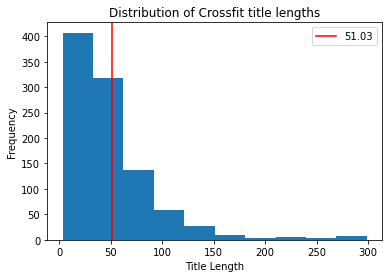

In [56]:
plt.title('Distribution of Crossfit title lengths')
plt.hist(gyms_df[gyms_df['subreddit'] == 'crossfit']['title_length'])
plt.axvline(gyms_df[gyms_df['subreddit'] == 'crossfit']['title_length'].mean(), color='red',
           label=str(np.round(gyms_df[gyms_df['subreddit'] == 'crossfit']['title_length'].mean(),
                             decimals=2)))
plt.xlabel('Title Length')
plt.ylabel('Frequency')
plt.legend();

plt.savefig('images/cf_title_length_distr.png')

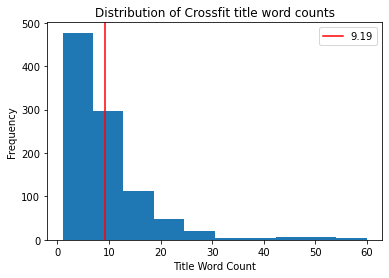

In [57]:
plt.title('Distribution of Crossfit title word counts')
plt.hist(gyms_df[gyms_df['subreddit'] == 'crossfit']['title_word_count'])
plt.axvline(gyms_df[gyms_df['subreddit'] == 'crossfit']['title_word_count'].mean(), color='red',
           label=str(np.round(gyms_df[gyms_df['subreddit'] == 'crossfit']['title_word_count'].mean(),
                             decimals=2)))
plt.xlabel('Title Word Count')
plt.ylabel('Frequency')
plt.legend();

plt.savefig('images/cf_title_wordct_distr.png')

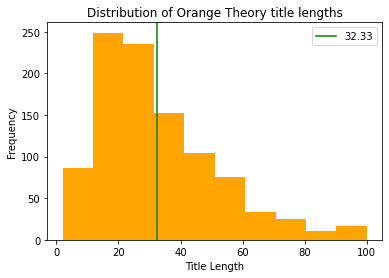

In [58]:
plt.title('Distribution of Orange Theory title lengths')
plt.hist(gyms_df[gyms_df['subreddit'] == 'orangetheory']['title_length'], color='orange')
plt.axvline(gyms_df[gyms_df['subreddit'] == 'orangetheory']['title_length'].mean(), color='green',
           label=str(np.round(gyms_df[gyms_df['subreddit'] == 'orangetheory']['title_length'].mean(),
                             decimals=2)))
plt.xlabel('Title Length')
plt.ylabel('Frequency')
plt.legend();

plt.savefig('images/otf_title_length_distr.png')

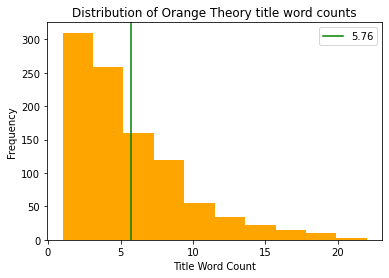

In [59]:
plt.title('Distribution of Orange Theory title word counts')
plt.hist(gyms_df[gyms_df['subreddit'] == 'orangetheory']['title_word_count'], color='orange')
plt.axvline(gyms_df[gyms_df['subreddit'] == 'orangetheory']['title_word_count'].mean(), color='green',
           label=str(np.round(gyms_df[gyms_df['subreddit'] == 'orangetheory']['title_word_count'].mean(),
                             decimals=2)))
plt.xlabel('Title Word Count')
plt.ylabel('Frequency')
plt.legend();

plt.savefig('images/otf_title_wordct_distr.png')

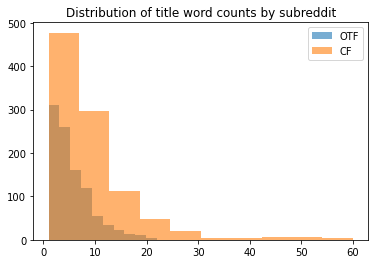

In [60]:
plt.hist(gyms_df[gyms_df['subreddit'] == 'orangetheory']['title_word_count'], alpha=.6, label='OTF')
plt.hist(gyms_df[gyms_df['subreddit'] == 'crossfit']['title_word_count'], alpha=.6, label='CF')
plt.legend()
plt.title('Distribution of title word counts by subreddit');

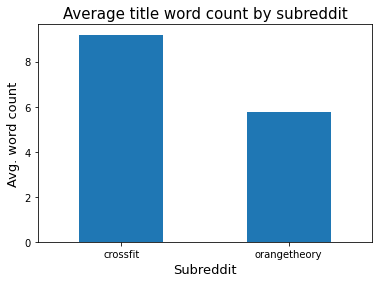

In [61]:
gyms_df.groupby('subreddit').mean()['title_word_count'].plot(kind='bar')
plt.title('Average title word count by subreddit', size=15)
plt.xticks(rotation=360)
plt.ylabel('Avg. word count', size=13)
plt.xlabel('Subreddit', size=13);

plt.savefig('images/avg_title_wordct_per_sub.png')

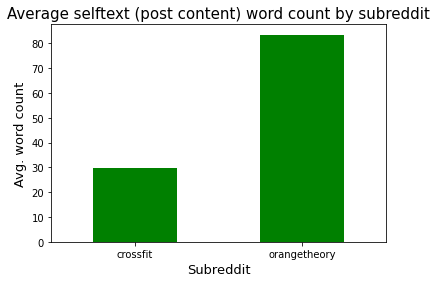

In [62]:
gyms_df.groupby('subreddit').mean()['selftext_word_count'].plot(kind='bar', color='green')
plt.title('Average selftext (post content) word count by subreddit', size=15)
plt.xticks(rotation=360)
plt.ylabel('Avg. word count', size=13)
plt.xlabel('Subreddit', size=13);

plt.savefig('images/avg_selftext_wordct_per_sub.png')

 Describe summary stats and distributions

#### Setting up Training/Testing Data

In [63]:
X = gyms_df['title']
y = gyms_df['sub_value']

##### Baseline Accuracy (OrangeTheory: 1 | Crossfit: 0)

In [64]:
y.value_counts(normalize = True)

1    0.502546
0    0.497454
Name: sub_value, dtype: float64

The baseline accuracy score of 50.25%, is saying that according to the null model we would be right about 50% of the time if we predicted a piece of text from the corpus data as belonging to the Orange Theory subreddit (the plurality class).

In [65]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    stratify=y,
                                                    random_state=42)

In [130]:
# Adding my custom stopwords list to sklearns 'english' stopword list
from sklearn.feature_extraction import text 

stop_words = text.ENGLISH_STOP_WORDS.union(my_stopwords)

In [141]:
cvec = CountVectorizer(stop_words = stop_words)

cvec.fit(X_train)
X_train_cv = cvec.transform(X_train)

X_test_cv = cvec.transform(X_test)

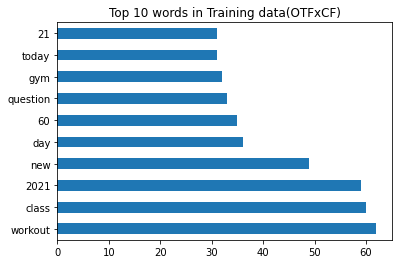

In [164]:
# Converting training data to dataframe
X_train_df = pd.DataFrame(X_train_cv.todense(), 
                          columns=cvec.get_feature_names())

# Plot of top 10 occuring words
X_train_df.sum().sort_values(ascending=False).head(10).plot(kind='barh')
plt.title('Top 10 words in Training data(OTFxCF)');

plt.savefig('images/top_words_gyms_df.png')

### Modeling

In [91]:
# Gridsearch was printing so many warnings, so I imported this to stop the warnings from showing
import warnings
warnings.filterwarnings(action='once')

warnings.filterwarnings('ignore')

##### Count Vectorizer Transformer Models

In [175]:
# CountVectorizer + LogReg 
pipe_cvec_logreg = Pipeline([
    ('cvec', CountVectorizer()),  
    ('logreg', LogisticRegression())                                  
])

# CountVectorizer + Multinomial Naive Bayes 
pipe_cvec_mnb = Pipeline([             
    ('cvec', CountVectorizer()),  
    ('mnb', MultinomialNB())                                           
])

# CountVectorizer + Random Forest    
pipe_cvec_rf = Pipeline([ 
('cvec', CountVectorizer()),      
('rf', RandomForestClassifier())                                       
])

##### TFIDF Transformer models

In [176]:
# TfidfVectorizer + LogReg 
pipe_tfidf_logreg = Pipeline([         
    ('tfidf', TfidfVectorizer()), 
    ('logreg', LogisticRegression())                                   
])

# TfidfVectorizer + Multinomial Naive Bayes 
pipe_tfidf_mnb = Pipeline([            
    ('tfidf', TfidfVectorizer()), 
    ('mnb', MultinomialNB())                                           
])

# TfidfVectorizer + Random Forest      
pipe_tfidf_rf = Pipeline([ 
('tfidf', TfidfVectorizer()),     
('rf', RandomForestClassifier())                                       
])  


##### Model Parameters

In [177]:
params_cvec_logreg = {
    'cvec__tokenizer': [Lemmatizer(), Stemmer(), None],
    'cvec__stop_words': ['english', None],
    'cvec__max_features' : [1000, 1500, 2000, None],
    'cvec__ngram_range': [(1,1), (1,2)],
    'cvec__max_df': [0.9, 0.95],
    'cvec__min_df': [2, 3],
    'logreg__C': [0.01, 0.1, 0.5, 1]
}

params_cvec_mnb = {
    'cvec__tokenizer': [Lemmatizer(), Stemmer(), None],
    'cvec__stop_words': ['english', None],
    'cvec__max_features' : [1000, 1500, 2000, None],
    'cvec__ngram_range': [(1,1), (1,2)],
    'cvec__max_df': [0.9, 0.95],
    'cvec__min_df': [2, 3],
    'mnb__alpha': [0.9, 0.95, 1]
}

params_cvec_rf = {
#     'cvec__tokenizer': [Lemmatizer(), Stemmer(), None],
    'cvec__stop_words': ['english', None],
    'cvec__max_features' : [1000, 1500, 2000, None],
    'cvec__ngram_range': [(1,1), (1,2)],
    'cvec__max_df': [0.9, 0.95],
    'cvec__min_df': [2, 3],
    'rf__n_estimators': [100, 150, 200],
    'rf__max_depth' : [None, 1, 2, 3, 5, 10]  
}



params_tfidf_logreg = {
    'tfidf__tokenizer': [Lemmatizer(), Stemmer(), None],
    'tfidf__stop_words': ['english', None],
    'tfidf__max_features' : [1000, 1500, 2000, None],
    'tfidf__ngram_range': [(1,1), (1,2)],
    'tfidf__max_df': [0.9, 0.95],
    'tfidf__min_df': [2, 3],
    'logreg__C': [0.01, 0.1, 0.5, 1],
}

params_tfidf_mnb = {
    'tfidf__tokenizer': [Lemmatizer(), Stemmer(), None],
    'tfidf__stop_words': ['english', None],
    'tfidf__max_features' : [1000, 1500, 2000, None],
    'tfidf__ngram_range': [(1,1), (1,2)],
    'tfidf__max_df': [0.9, 0.95],
    'tfidf__min_df': [2, 3],
    'mnb__alpha': [0.9, 0.95, 1]
}

params_tfidf_rf = {
#     'tfidf__tokenizer': [Lemmatizer(), Stemmer(), None],
    'tfidf__stop_words': ['english', None],
    'tfidf__max_features' : [1000, 1500, 2000, None],
    'tfidf__ngram_range': [(1,1), (1,2)],
    'tfidf__max_df': [0.9, 0.95],
    'tfidf__min_df': [2, 3],
    'rf__n_estimators': [100, 150, 200],
    'rf__max_depth' : [None, 1, 2, 3, 5, 10]  
}

#### Pipeline Models

##### CountVectorizer-Logistic Regression

In [191]:
pipe_cvec_logreg.fit(X_train, y_train)

print(f"Training Score(CVEC-LOGREG): {pipe_cvec_logreg.score(X_train, y_train)}")

print(f"Testing Score(CVEC-LOGREG): {pipe_cvec_logreg.score(X_test, y_test)}")

print(f"Avg. Cross-Val Score(CVEC-LOGREG): {cross_val_score(pipe_cvec_logreg, X_train, y_train, cv=5 ).mean()}")

Training Score(CVEC-LOGREG): 0.9775967413441955
Testing Score(CVEC-LOGREG): 0.8207739307535642
Avg. Cross-Val Score(CVEC-LOGREG): 0.81395826127061


##### CountVectorizer-Multinomial Naive Bayes

In [192]:
pipe_cvec_mnb.fit(X_train, y_train)

print(f"Training Score(CVEC-MNB): {pipe_cvec_mnb.score(X_train, y_train)}")

print(f"Testing Score(CVEC-MNB): {pipe_cvec_mnb.score(X_test, y_test)}")

print(f"Avg. Cross-Val Score(CVEC-MNB): {cross_val_score(pipe_cvec_mnb, X_train, y_train, cv=5 ).mean()}")

Training Score(CVEC-MNB): 0.945010183299389
Testing Score(CVEC-MNB): 0.8085539714867617
Avg. Cross-Val Score(CVEC-MNB): 0.8234797647872709


##### CountVectorizer-Random Forest

In [193]:
pipe_cvec_rf.fit(X_train, y_train)

print(f"Training Score(CVEC-RF): {pipe_cvec_rf.score(X_train, y_train)}")

print(f"Testing Score(CVEC-RF): {pipe_cvec_rf.score(X_test, y_test)}")

print(f"Avg. Cross-Val Score(CVEC-RF): {cross_val_score(pipe_cvec_rf, X_train, y_train, cv=5 ).mean()}")

Training Score(CVEC-RF): 0.9986422267481331
Testing Score(CVEC-RF): 0.824847250509165
Avg. Cross-Val Score(CVEC-RF): 0.784088550674507


##### TF-IDF Vectorizer-Logistic Regression

In [196]:
pipe_tfidf_logreg.fit(X_train, y_train)

print(f"Training Score(TFIDF-LOGREG): {pipe_tfidf_logreg.score(X_train, y_train)}")

print(f"Testing Score(TFIDF-LOGREG): {pipe_tfidf_logreg.score(X_test, y_test)}")

print(f"Avg. Cross-Val Score(TFIDF-LOGREG): {cross_val_score(pipe_tfidf_logreg, X_train, y_train, cv=5 ).mean()}")

Training Score(TFIDF-LOGREG): 0.955193482688391
Testing Score(TFIDF-LOGREG): 0.8167006109979633
Avg. Cross-Val Score(TFIDF-LOGREG): 0.8193889081056153


##### TF-IDF Vectorizer-Multinomial Naive Bayes

In [194]:
pipe_tfidf_mnb.fit(X_train, y_train)

print(f"Training Score(TFIDF-MNB): {pipe_tfidf_mnb.score(X_train, y_train)}")

print(f"Testing Score(TFIDF-MNB): {pipe_tfidf_mnb.score(X_test, y_test)}")

print(f"Avg. Cross-Val Score(TFIDF-MNB): {cross_val_score(pipe_tfidf_mnb, X_train, y_train, cv=5 ).mean()}")

Training Score(TFIDF-MNB): 0.9613034623217923
Testing Score(TFIDF-MNB): 0.8187372708757638
Avg. Cross-Val Score(TFIDF-MNB): 0.8289034936008302


##### TF-IDF Vectorizer-Random Forest

In [195]:
pipe_tfidf_rf.fit(X_train, y_train)

print(f"Training Score(TFIDF-MNB): {pipe_tfidf_rf.score(X_train, y_train)}")

print(f"Testing Score(TFIDF-MNB): {pipe_tfidf_rf.score(X_test, y_test)}")

print(f"Avg. Cross-Val Score(TFIDF-MNB): {cross_val_score(pipe_tfidf_rf, X_train, y_train, cv=5 ).mean()}")

Training Score(TFIDF-MNB): 0.9986422267481331
Testing Score(TFIDF-MNB): 0.8126272912423625
Avg. Cross-Val Score(TFIDF-MNB): 0.7759483454398708


#### Gridsearch Models

##### CountVectorizer-Logistic Regression

In [122]:
gs_cvec_logreg = GridSearchCV(pipe_cvec_logreg, 
                  param_grid=params_cvec_logreg, 
                  cv=5) 

gs_cvec_logreg.fit(X_train, y_train)

print(gs_cvec_logreg.best_score_)

0.8119335869941198


In [123]:
gs_cvec_logreg.best_params_

{'cvec__max_df': 0.9,
 'cvec__max_features': 1000,
 'cvec__min_df': 2,
 'cvec__ngram_range': (1, 1),
 'cvec__stop_words': 'english',
 'cvec__tokenizer': None,
 'logreg__C': 0.5}

##### CountVectorizer-Multinomial Naive Bayes

In [126]:
gs_cvec_mnb = GridSearchCV(pipe_cvec_mnb, 
                  param_grid=params_cvec_mnb, 
                  cv=5) 

gs_cvec_mnb.fit(X_train, y_train)

print(gs_cvec_mnb.best_score_)

0.8146431453937506


In [127]:
gs_cvec_mnb.best_params_

{'cvec__max_df': 0.9,
 'cvec__max_features': 1500,
 'cvec__min_df': 2,
 'cvec__ngram_range': (1, 2),
 'cvec__stop_words': 'english',
 'cvec__tokenizer': None,
 'mnb__alpha': 0.95}

##### CountVectorizer-Random Forest

In [130]:
gs_cvec_rf = GridSearchCV(pipe_cvec_rf, 
                  param_grid=params_cvec_rf, 
                  cv=5) 

gs_cvec_rf.fit(X_train, y_train)

print(gs_cvec_rf.best_score_)


0.7997186671278682


In [132]:
print(gs_cvec_rf.best_params_)

{'cvec__max_df': 0.95, 'cvec__max_features': 1000, 'cvec__min_df': 2, 'cvec__ngram_range': (1, 2), 'cvec__stop_words': 'english', 'rf__max_depth': None, 'rf__n_estimators': 100}


##### TF-IDF Vectorizer-Logistic Regression

In [133]:
gs_tfidf_logreg = GridSearchCV(pipe_tfidf_logreg, 
                  param_grid=params_tfidf_logreg, 
                  cv=5) 

gs_tfidf_logreg.fit(X_train, y_train)

print(gs_tfidf_logreg.best_score_)

0.8092032745301511


##### TF-IDF Vectorizer-Multinomial Naive Bayes

In [130]:
gs_tfidf_mnb = GridSearchCV(pipe_tfidf_mnb, 
                  param_grid=params_tfidf_mnb, 
                  cv=5) 

gs_tfidf_mnb.fit(X_train, y_train)

print(gs_tfidf_mnb.best_score_)
print(gs_tfidf_mnb.best_params_)

0.8126161651101118
{'mnb__alpha': 1, 'tfidf__max_df': 0.9, 'tfidf__max_features': 1500, 'tfidf__min_df': 2, 'tfidf__ngram_range': (1, 2)}


##### TF-IDF Vectorizer-Random Forest

In [132]:
gs_tfidf_rf = GridSearchCV(pipe_tfidf_rf, 
                  param_grid=params_tfidf_rf, 
                  cv=5) 

gs_tfidf_rf.fit(X_train, y_train)

print(gs_tfidf_rf.best_score_)
print(gs_tfidf_rf.best_params_)

0.7963150005765017
{'rf__max_depth': None, 'tfidf__max_df': 0.9, 'tfidf__max_features': None, 'tfidf__min_df': 2, 'tfidf__ngram_range': (1, 2)}


### Best Model

##### TF-IDF Vectorizer-Multinomial Naive Bayes

In [194]:
pipe_tfidf_mnb.fit(X_train, y_train)

print(f"Training Score(TFIDF-MNB): {pipe_tfidf_mnb.score(X_train, y_train)}")

print(f"Testing Score(TFIDF-MNB): {pipe_tfidf_mnb.score(X_test, y_test)}")

print(f"Avg. Cross-Val Score(TFIDF-MNB): {cross_val_score(pipe_tfidf_mnb, X_train, y_train, cv=5 ).mean()}")

Training Score(TFIDF-MNB): 0.9613034623217923
Testing Score(TFIDF-MNB): 0.8187372708757638
Avg. Cross-Val Score(TFIDF-MNB): 0.8289034936008302


In [199]:
# Predictions
best_preds = pipe_tfidf_mnb.predict(X_test)

# Confusion matrix values
tn, fp, fn, tp = confusion_matrix(y_test, best_preds).ravel()

# Specificity
spec = tn / (tn + fp)

print('Specificity:', spec)

Specificity: 0.8278688524590164


Specificity Metric was used to show the ability of my model to correctly identify each subreddit. So, 82% of the time my model correctly predicts the subreddit, as opposed to 50% of the null model.

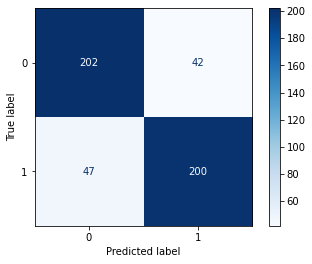

In [202]:
# Plot confusion matrix
plot_confusion_matrix(pipe_tfidf_mnb, X_test, y_test, cmap='Blues', values_format='d');
plt.savefig('images/conf_matrix.png')

### Sentiments Analysis

#### EDA of OTF and CF dataframes

In [115]:
otf_df.head()

,author_fullname,title,selftext,score,subreddit
0,t2_38cndng5,Disc replacement,Not looking for medical advice just curious if...,1,orangetheory
1,t2_4k54qa7s,What are your cues that you need a few days off?,How can you tell when you need to take a few d...,3,orangetheory
2,t2_8162kxd9,Burnsville or Apple Valley MN studio,"I will be in Lakeville MN next week, thinking ...",2,orangetheory
3,t2_ct4fexde,OTF… Feels like the 80’’s Highschool Cliche - ...,[removed],1,orangetheory
4,t2_3wl9qh0n,"Daily Workout and General Chat for Saturday, 6...",Use this post to discuss today's OTF workout o...,8,orangetheory


In [142]:
otf_df.isnull().sum().sort_values(ascending=False)

author_fullname    0
title              0
selftext           0
score              0
subreddit          0
dtype: int64

In [139]:
otf_df.duplicated().sum()

0

In [138]:
otf_df.drop_duplicates(keep='first', inplace=True)

In [141]:
otf_df.drop(otf_df[otf_df['author_fullname'].isna()].index, inplace=True)

In [145]:
otf_df['selftext'].replace({'[removed]': '', '[deleted]': ''}, inplace=True)

In [189]:
otf_df.drop(otf_df[otf_df['selftext'] == ''].index, inplace=True)

In [190]:
otf_df.shape

(844, 5)

In [153]:
cf_df.isnull().sum().sort_values(ascending=False)

author_fullname    0
title              0
selftext           0
score              0
subreddit          0
dtype: int64

In [158]:
cf_df.duplicated().sum()

0

In [157]:
cf_df.drop_duplicates(keep='first', inplace=True)

In [152]:
cf_df.drop(cf_df[cf_df['author_fullname'].isna()].index, inplace=True)

In [154]:
cf_df['selftext'].replace({'[removed]': '', '[deleted]': ''}, inplace=True)

In [187]:
cf_df.drop(cf_df[cf_df['selftext'] == ''].index, inplace=True)

In [188]:
cf_df.shape

(341, 5)

#### Instantiating Sentiment Analyzer

In [167]:
sia = SentimentIntensityAnalyzer()

#### SIA for OTF 'title'

In [180]:
sia_dicts_otf = [sia.polarity_scores(post) for post in otf_df['title']]

sia_df_otf = pd.DataFrame(sia_dicts_otf)

sia_df_otf.sort_values(by='compound', ascending=False).head()

,neg,neu,pos,compound
80,0.0,0.537,0.463,0.8842
683,0.0,0.433,0.567,0.8342
923,0.0,0.667,0.333,0.8176
141,0.0,0.647,0.353,0.8016
245,0.0,0.464,0.536,0.7959


In [195]:
sia_df_otf.describe()

,neg,neu,pos,compound
count,987.000000,987.000000,987.000000,987.000000
mean,0.054322,0.864228,0.081451,0.025959
std,0.154718,0.229225,0.182385,0.239759
min,0.000000,0.000000,0.000000,-0.812600
25%,0.000000,0.738500,0.000000,0.000000
50%,0.000000,1.000000,0.000000,0.000000
75%,0.000000,1.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,0.884200


#### Polarity Scores for CF 'title'

In [176]:
sia_dicts_cf = [sia.polarity_scores(post) for post in cf_df['title']]

sia_df_cf = pd.DataFrame(sia_dicts_cf)

sia_df_cf.sort_values(by='compound', ascending=False).head()

In [177]:
sia_df_cf.describe()

,neg,neu,pos,compound
count,975.000000,975.000000,975.000000,975.000000
mean,0.056265,0.837358,0.106376,0.093832
std,0.136578,0.211725,0.178028,0.320572
min,0.000000,0.000000,0.000000,-0.836000
25%,0.000000,0.686000,0.000000,0.000000
50%,0.000000,1.000000,0.000000,0.000000
75%,0.000000,1.000000,0.204000,0.310800
max,1.000000,1.000000,1.000000,0.948900


#### Polarity Scores for OTF 'selftext'

In [191]:
sia_dicts_otf_txt = [sia.polarity_scores(post) for post in otf_df['selftext']]

sia_df_otf_txt = pd.DataFrame(sia_dicts_otf_txt)

sia_df_otf_txt.sort_values(by='compound', ascending=False).head()

,neg,neu,pos,compound
112,0.102,0.680,0.218,0.9972
681,0.038,0.747,0.214,0.9971
141,0.054,0.730,0.216,0.9964
697,0.047,0.658,0.295,0.9959
90,0.028,0.834,0.138,0.9954


In [192]:
sia_df_otf_txt.describe()

,neg,neu,pos,compound
count,844.000000,844.000000,844.000000,844.000000
mean,0.054960,0.831831,0.113216,0.285472
std,0.060359,0.098168,0.090958,0.628662
min,0.000000,0.000000,0.000000,-0.997200
25%,0.000000,0.769750,0.050750,-0.190925
50%,0.042000,0.839000,0.103000,0.501650
75%,0.088000,0.890000,0.161000,0.827350
max,0.438000,1.000000,1.000000,0.997200


#### Polarity Scores for CF 'selftext'

In [193]:
sia_dicts_cf_txt = [sia.polarity_scores(post) for post in cf_df['selftext']]

sia_df_cf_txt = pd.DataFrame(sia_dicts_cf_txt)

sia_df_cf_txt.sort_values(by='compound', ascending=False).head()

,neg,neu,pos,compound
306,0.014,0.744,0.242,0.9937
235,0.036,0.753,0.212,0.9920
53,0.000,0.786,0.214,0.9867
11,0.000,0.821,0.179,0.9866
148,0.000,0.525,0.475,0.9860


In [194]:
sia_df_cf_txt.describe()

,neg,neu,pos,compound
count,341.000000,341.000000,341.000000,341.000000
mean,0.047935,0.833774,0.118287,0.385459
std,0.066213,0.102247,0.092725,0.571745
min,0.000000,0.514000,0.000000,-0.965400
25%,0.000000,0.778000,0.056000,0.000000
50%,0.028000,0.829000,0.106000,0.593100
75%,0.070000,0.904000,0.182000,0.877700
max,0.482000,1.000000,0.475000,0.993700


### Conclusion and Recommendations

My model did fairly well at predicting subreddits. The distribution of word counts and character length provided a good way to differntiate between the to subreddits. I would have liked to incorporate that into my model features to see if it would have improved the accuracy score. 

The gridsearch models, while they took a long time to run through numerous hyperparameters, did no better and at times even worse than the default pipeline models. I learned from this that more parameters don't necessarily mean better results.

Unfortunately, the Sentiment Analysis did not provide any significant data in determining which fitness community was happier with their workouts. The compound scores for the title and selftext of each subreddit's post were overwhelmingly low, and neutral. Going forward I think it would do better with a lot more data, and more in depth EDA to filter out a lot of unnecessary words that cloud the analyzer. An interesting aspect I did discover from the posts during cleaning and analysis was that, a good number of users from both communities tend to treat the message boards as personal ads. The contents of most of the posts were a bit racy, and I discovered as well during tokenizing and lemmatizing that a number of words were being split on the letters 'M' and 'F'. After further analysis, I discovered that the posts were punctuating these letters with brackets to denote 'Male' and 'Female'.

Although I was unable to answer which community was happier, I discovered a lot of little nuances during natural text EDA that will help me in future projects.